## The Disordered TF Ising model

If we now add spatial disorder to the bonds and fields, the Ising Hamiltonian reads

\begin{equation*}
H(t)=-J \sum_{i}^{N-1} \big(1+\alpha J_{i}\big) \sigma_{i}^{x} \sigma_{i+1}^{x}-\sum_{i}^{N}\left\{h_{0} \sin (\omega t)+\alpha h_{i}\right\} \sigma_{i}^{z}
\end{equation*}

where $J_i, h_i$ are random numbers drawn from the range $[-1,1]$, and $\alpha$ is the disorder strength. A Jordan-Wigner transformation to fermions leads to the Hamiltonian [REFS: fate paper and Bigan Mbeng et al 2020]
\begin{equation*}
\widehat{H}(t)=\left(\hat{\mathbf{c}}^{\dagger}, \hat{\mathbf{c}}\right)\left(\begin{array}{cc}
\mathbf{A}(t) & \mathbf{B} \\
-\mathbf{B} & -\mathbf{A}(t)
\end{array}\right)\left(\begin{array}{l}
\hat{\mathbf{c}} \\
\hat{\mathbf{c}}^{\dagger}
\end{array}\right),
\end{equation*}
with the Nambu Spinors
\begin{equation*}
\left(\hat{\mathbf{c}}^{\dagger}, \hat{\mathbf{c}}\right) = \left(\hat{c}_{1}^{\dagger}, \cdots, \hat{c}_{N}^{\dagger}, \hat{c}_{1}, \cdots, \hat{c}_{N}\right),
\end{equation*}
and the matrices
\begin{align*}
\mathbf{A}(t) &= h(t)\times\mathbf{1} +\alpha \big(\mathbf{h} + \mathbf{J}/2\big)+\mathbf{D}/2\\
\mathbf{B}(t) &=\frac12 \big(\mathbf{\overline{D}} + \alpha J \mathbf{\overline{J}}\big)\\
h(t) &= h_0 + h\cos{\omega t}.
\end{align*}
Here, the matrix components of $\mathbf{h}$ are $\mathbf{h}_{ij} = h_i\delta_{ij}$, the matrix $\mathbf{J}$ is a tridiagonal symmetric matrix with components $J_i$ along the super and sub-diagonals, and $\mathbf{\overline{J}}$ is a tridiagonal antisymmetric matrix with components $\mp J_i$ along the super (sub) diagonals. Finally, the matrix $\mathbf{D}$ is a tridiagonal symmetric matrix with $1$ along the super and sub-diagonals, and $\mathrm{\overline{D}}$ is a tridiagonal anti-symmetric matrix with $\mp 1$ along the super (sub) diagonals.

Thus, the dynamics of the full system lies entirely on an invariant subspace of size $2N\times 2N$. Note that the formulae above only hold for open boundary conditions. The IPR of the Floquet states can now be computed in a manner similar to the clean Ising model discussed above, except with $2N$ components. In more qutip-friendly notation, the effective $2N\times 2N$ Hamiltonian 
\begin{align*}
\overline{H}(t) &= \overline{H}_0 + h(t)\overline{H}_1\\
\overline{H}_0 &=  \begin{pmatrix}\alpha \big(\mathbf{h} + \mathbf{J}/2\big) + \mathbf{D}/2 & \mathbf{0}\\ \mathbf{0} & -\alpha \big(\mathbf{h}+\mathbf{J}/2\big)-\mathbf{D}/2 \end{pmatrix} + \frac12\begin{pmatrix}\mathbf{0} & \big(\mathbf{\overline{D}} + \alpha J\mathbf{\overline{J}}\big)\\-\big(\mathbf{\overline{D}}+\alpha J\mathbf{\overline{J}}\big) & \mathbf{0}\end{pmatrix}\\
\overline{H}_1 &=  \begin{pmatrix}\mathbf{1} & \mathbf{0} \\ \mathbf{0} & -\mathbf{1} \end{pmatrix}
\end{align*}
Finally, in the actual time evolution, the hamiltonian has to be doubled.

In [4]:
from datetime import datetime
print(datetime.now())
import numpy as np
from qutip import Qobj, basis, mesolve, Options
from scipy.special import j0

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.sin(w * t)

def get_disorder_hamilts(args):
    N= args['N']
    alpha = args["alpha"]
    # Construct the Hamiltonian
    bonds = np.random.uniform(-1,1,N-1)
    fields = np.random.uniform(-1,1,N)
    
    hmat = np.diag(fields)
    jmat = np.diag(bonds, k=1) + np.diag(bonds, k=-1)
    jmat_bar = -np.diag(bonds, k=1) + np.diag(bonds, k=-1)
    
    dmat = np.diag(np.ones(N-1), k=1) + np.diag(np.ones(N-1), k=-1)
    dmat_bar = - np.diag(np.ones(N-1), k=1) + np.diag(np.ones(N-1), k=-1)
    
    H0 = np.zeros((2*N, 2*N))
    H1 = np.zeros((2*N, 2*N))
    
    H0[0:N,0:N] = alpha * (hmat + jmat/2) + dmat/2
    H0[N:,N:] = -alpha * (hmat + jmat/2) - dmat/2
    
    H0[0:N, N:] = 0.5 * ( dmat_bar + alpha * jmat_bar)
    H0[N:, 0:N] = - 0.5 *(dmat_bar +  alpha * jmat_bar)
    
    d = np.ones(2*N)
    d[N:] = -1
    H1 = np.diag(d)
    return 2 * H0, 2 * H1
    
def get_floquet_isingdisorder(args, **kwargs):
    N = args['N']
    H0, H1 = get_disorder_hamilts(args)
    H = [Qobj(H0),[Qobj(H1),drive]] 
    T = 2 * np.pi/args['omega']
    f_mat = np.empty((2*N, 2*N), dtype=np.complex128)
    for i in range(2*N):
        baseket = basis(2*N,i)
        solv_state = mesolve(H, baseket, [0,T], [], [], args = args, **kwargs)
        final = solv_state.states[-1].full().flatten()
        f_mat[:,i] = final
    
    _, f_estates = np.linalg.eig(f_mat)
    return f_estates

def get_iprvals_disorder(args, **kwargs):
    floquet_matrix = get_floquet_isingdisorder(args, **kwargs)   
    return np.sum(np.abs(floquet_matrix)**4, axis=0)

2022-08-16 14:21:18.972472


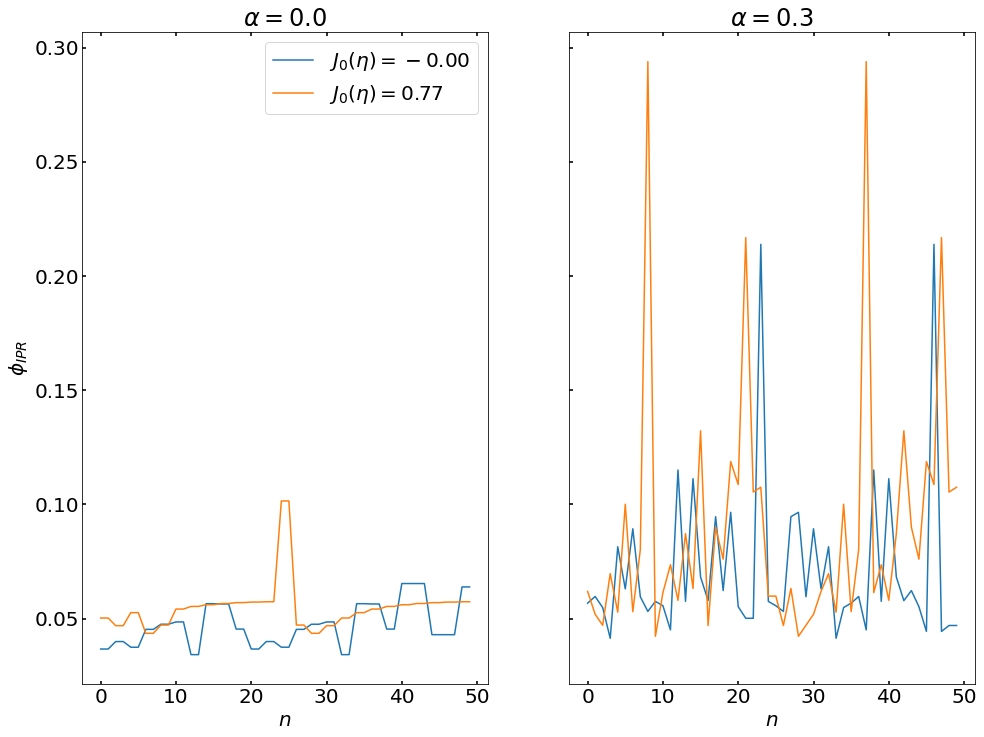

In [3]:
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
plt.rcParams.update({
    "figure.figsize": (16, 12),
    "text.usetex": False,
    "font.size": 20})

N = 25

h0 = 0
h = 7.0
alpha = 0.0

etas = jn_zeros(0,4)
eta = etas[1]
w_frz = 2*h/eta

w_nfrz = 2*h

#Qutip Solver Options
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

fig, axs = plt.subplots(1,2, sharey=True)

for i, alpha in enumerate([0.0, 0.3]):
    params_frz = {'h0':h0, 'h': h, 'omega': w_frz, 'alpha': alpha, 'N':N}
    params_nfrz = {'h0':h0, 'h': h, 'omega': w_nfrz, 'alpha': alpha, 'N':N}
    axs[i].set_title(r'$\alpha={:1.1f}$'.format(alpha))

    for p in (params_frz, params_nfrz):
        M = get_iprvals_disorder(p, options=opts)
        
        axs[i].plot(M[::-1],label=r'$J_0(\eta) ={:1.2f} $'.format(j0(2*p['h']/p['omega'])))
        
        axs[i].set_xlabel(r'$n$')
        #axs[i].set_ylim(-0.03, 1.03)
        
axs[0].set_ylabel(f'$\phi_{{IPR}}$')
axs[0].legend()
#plt.savefig('isingdisorder_ipr_jali.svg')
plt.show()

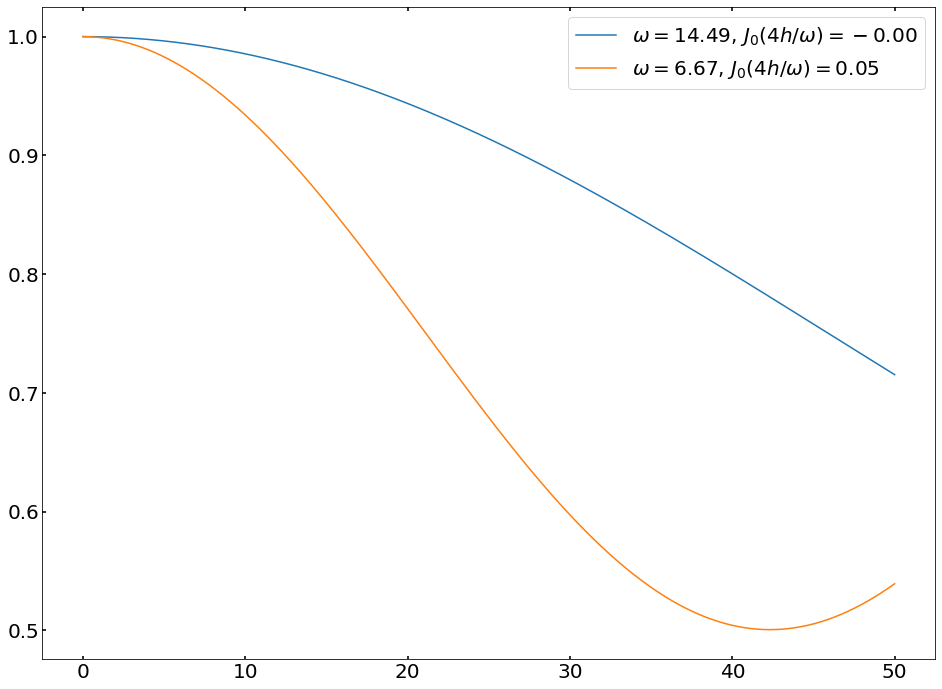

In [23]:
from qutip import propagator
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
plt.rcParams.update({
    "figure.figsize": (16, 12),
    "text.usetex": False,
    "font.size": 20})

N = 50

h0 = 0
h = 20.0
alpha = 0.0

etas = jn_zeros(0,4)
eta = etas[1]
w_frz = 4*h/eta

w_nfrz = h/3

#Qutip Solver Options
opts = Options(nsteps=1e5, openmp_threads=1)
params_frz = {'h0':h0, 'h': h, 'omega': w_frz, 'alpha': alpha, 'N':N}
params_nfrz = {'h0':h0, 'h': h, 'omega': w_nfrz, 'alpha': alpha, 'N':N}

for w in [w_frz, w_nfrz]:
    p = {'h0':h0, 'h': h, 'omega': w, 'alpha': alpha, 'N':N}
    H0, H1 = get_disorder_hamilts(p)
    H = [Qobj(H0)/N,[Qobj(H1)/N,drive]] 
    
    h = p['h']
    w = p['omega']
    T = 2 * np.pi/w
    n = 50
    times = np.linspace(0,n*T, 500)

    Ut = propagator(H, times, c_op_list=[], args=params_frz, options=None, parallel=True)
    G = [np.trace(U[0:N,0:N] @ U[0:N,0:N].T.conjugate())/N for U in Ut]
    plt.plot(times/T, np.abs(G), label=r'$\omega = {:1.2f}$, $J_0(4h/\omega)={:1.2f}$'.format(w, j0(4*h/w)))
    
plt.legend()
plt.show()